In [1]:
from CookieTTS._2_ttm.untts.model import UnTTS
from CookieTTS._2_ttm.untts.model import load_model
from CookieTTS._2_ttm.untts.hparams import create_hparams
from CookieTTS.utils.audio.stft import TacotronSTFT, STFT
from CookieTTS.utils.text import text_to_sequence

import sys
sys.path.append('../_4_mtw/waveglow') # add WaveGlow to System path for easier importing
import os
import numpy as np
import torch

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd

D:\Miniconda\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
D:\Miniconda\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
def plot_data(data, title=None, figsize=(20, 3.5)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        if title:
            axes[i].set_title(title[i])
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

In [3]:
import json

waveglow_path = r"H:\TTCheckpoints\waveflow\4thLargeKernels\AR_10_Flow\best_val_model"
config_fpath = r"H:\TTCheckpoints\waveflow\4thLargeKernels\AR_10_Flow\config.json"

def is_ax(config):
    """Quickly check if a model uses the Ax WaveGlow core by what's available in the config file."""
    return True if 'upsample_first' in config.keys() else False

# Load config file
with open(config_fpath) as f:
    data = f.read()
config = json.loads(data)
train_config = config["train_config"]
data_config = config["data_config"]
dist_config = config["dist_config"]
waveglow_config = {
    **config["waveglow_config"], 
    'win_length': data_config['win_length'],
    'hop_length': data_config['hop_length']
}
print(waveglow_config)
print(f"Config File from '{config_fpath}' successfully loaded.")

# import the correct model core
if is_ax(waveglow_config):
    from CookieTTS._4_mtw.waveglow.efficient_model_ax import WaveGlow
else:
    if waveglow_config["yoyo"]:
        from CookieTTS._4_mtw.waveglow.efficient_model import WaveGlow
    else:
        from CookieTTS._4_mtw.waveglow.glow import WaveGlow
from CookieTTS._4_mtw.waveglow.denoiser import Denoiser

# initialize model
print(f"intializing WaveGlow model... ", end="")
waveglow = WaveGlow(**waveglow_config).cuda()
print(f"Done!")

# load checkpoint from file
print(f"loading WaveGlow checkpoint... ", end="")
checkpoint = torch.load(waveglow_path)
waveglow.load_state_dict(checkpoint['model']) # and overwrite initialized weights with checkpointed weights
waveglow.cuda().eval().half() # move to GPU and convert to half precision
waveglow.remove_weightnorm()
print(f"Done!")

print(f"initializing Denoiser... ", end="")
denoiser = Denoiser(waveglow)
print(f"Done!")
waveglow_iters = checkpoint['iteration']
print(f"WaveGlow trained for {waveglow_iters} iterations")
speaker_lookup = checkpoint['speaker_lookup'] # ids lookup
training_sigma = train_config['sigma']

{'shift_spect': 11.52, 'scale_spect': 0.25, 'preceived_vol_scaling': False, 'waveflow': True, 'channel_mixing': 'permute', 'mix_first': False, 'n_flows': 12, 'n_group': 20, 'n_early_every': 16, 'n_early_size': 2, 'memory_efficient': 0.0, 'spect_scaling': False, 'upsample_mode': 'normal', 'WN_config': {'gated_unit': 'GTU', 'n_layers': 8, 'n_channels': 128, 'kernel_size_w': 7, 'kernel_size_h': 7, 'n_layers_dilations_w': None, 'n_layers_dilations_h': 1, 'speaker_embed_dim': 96, 'rezero': False, 'cond_layers': 3, 'cond_activation_func': 'lrelu', 'cond_out_activation_func': False, 'negative_slope': 0.5, 'cond_hidden_channels': 256, 'cond_padding_mode': 'zeros', 'seperable_conv': True, 'res_skip': True, 'merge_res_skip': False, 'upsample_mode': 'linear', 'cond_kernel_size': 1}, 'n_mel_channels': 160, 'speaker_embed': 96, 'cond_layers': 3, 'cond_activation_func': 'lrelu', 'negative_slope': 0.5, 'cond_hidden_channels': 256, 'cond_output_channels': 256, 'cond_residual': True, 'cond_res_rezero':

In [4]:
#hparams = create_hparams()

In [6]:
checkpoint_paths = [
    #r"G:\TwiBot\CookiePPPTTS\CookieTTS\_2_ttm\untts\outdir\best_model",
    r"G:\TwiBot\CookiePPPTTS\CookieTTS\_2_ttm\untts\outdir\checkpoint_15000_gmmatt",
]

texts = [
    "printing,",
    "esssssssssss",
    "One... Two three four!",
    "So either more accurate alignment information or a higher kernel size inside the decoder might get Flow Tee Tee ess to speak it's first coherent words.",
    "Starlight Glimmer finally learns the identity of her long-lost mother. It's somepony she knows very well.",
]

sigma = [0.2,0.5,0.95]
wg_sigma = 0.95

# Speaker IDs
speaker_ids = torch.LongTensor([0,]).cuda()
print('Speaker ID =', speaker_ids)
# Generate
with torch.no_grad():
    for sigma_ in sigma:
        for i, checkpoint_path in enumerate(checkpoint_paths):
            print(f'Loading "{checkpoint_path}"')
            if os.path.exists(checkpoint_path):
                checkpoint = torch.load(checkpoint_path)
            else:
                print('Checkpoint does not Exist\n\n')
                continue
            iteration = checkpoint['iteration']
            hparams = checkpoint['hparams']
            hparams.melenc_drop_rate = .0
            hparams.decoder_padding_value = .0
            hparams.use_duration_predictor_for_attention = True
            hparams.use_duration_predictor_for_inference = False
            hparams.use_GMMAttention = False
            print(f"On iter {iteration}")
            model = load_model(hparams)
            pretrained_dict = checkpoint['state_dict']
            model_dict = model.state_dict()
            filtered_dict = {k: v for k, v in pretrained_dict.items() if (k in model_dict.keys()) and (pretrained_dict[k].shape == model_dict[k].shape)}
            model.load_state_dict(filtered_dict)
            _ = model.cuda().eval()
            mel_outputs = []
            alignments = []
            titles=[]
            for text in texts:
                sequence = np.array(text_to_sequence(text, ['basic_cleaners']))[None, :]
                sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
                mel_output, alignment, *_ = model.inference(sequence, speaker_ids, sigma=sigma_)
                alignment = alignment.transpose(-2, -1) if alignment is not None else None
                print(f'Text: {"`"+text+"`":30} [mean {mel_output.mean().item():.6f}] [max {mel_output.max().item():.6f}] [min {mel_output.min().item():.6f}]')
                audio = waveglow.infer(mel_output.half(), speaker_ids=speaker_ids, sigma=wg_sigma)
                denoised_audio = denoiser(audio, strength=0.1)
                ipd.display(ipd.Audio(audio[0].cpu().numpy(), rate=hparams.sampling_rate))
                ipd.display(ipd.Audio(denoised_audio[0].cpu().numpy(), rate=hparams.sampling_rate))
                
                mel_outputs.append(mel_output)
                alignments.append(alignment)
                titles.append(f"Flow-TTS Iter {iteration}\nText: '{text}'\nSigma: {sigma_}\nMax: {mel_output.max().item():.6f}\nMin: {mel_output.min().item():.6f}")
            plot_data((*[x.float().cpu().numpy()[0] for x in mel_outputs],), title=titles)
            if 1 and alignments[0] is not None:
                if len(alignments[0].shape) == 4:
                    for head_id in range(alignments[0].shape[1]):
                        plot_data((*[x[0][head_id].float().cpu().numpy() for x in alignments],), title=[f'layer: {head_id}',]*len(alignments), figsize=(20, 2))
                else:
                    plot_data((*[x[0].float().cpu().numpy() for x in alignments],), figsize=(20, 2))

Speaker ID = tensor([0], device='cuda:0')
Loading "G:\TwiBot\CookiePPPTTS\CookieTTS\_2_ttm\untts\outdir\checkpoint_15000_gmmatt"


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-5a4941b1997d>", line 26, in <module>
    checkpoint = torch.load(checkpoint_path)
  File "D:\Miniconda\lib\site-packages\torch\serialization.py", line 593, in load
    return _legacy_load(opened_file, map_location, pickle_module, **pickle_load_args)
  File "D:\Miniconda\lib\site-packages\torch\serialization.py", line 780, in _legacy_load
    deserialized_objects[key]._set_from_file(f, offset, f_should_read_directly)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterr

KeyboardInterrupt: 

In [1]:
!pip install syllables

The system cannot find the path specified.
You should consider upgrading via the 'd:\miniconda\python.exe -m pip install --upgrade pip' command.


In [2]:
import syllables
syllables.estimate('estimate')

4

In [19]:
import torch
import syllables
text = """{IH1 T} {AO1 L} {B IY0 G AE1 N} {AE1 Z} {AE1 N} {AE1 K S AH0 D AH0 N T}."""
text2 = """It all began as an accident."""
def get_syllables_per_second(text, duration):
    if '{' in text:
        n_syl = sum([len([x for x in t.split(' ') if x.strip()]) for t in text.split('{')])
    else:
        n_syl = syllables.estimate(text)
    sylps = n_syl/duration
    return torch.tensor(sylps)
print(
    get_syllables_per_second('they scored a goal!', 10),
    get_syllables_per_second(text, 10),
    get_syllables_per_second(text2, 10),
    )

tensor(0.5000) tensor(2.1000) tensor(0.8000)


In [77]:
labels = torch.tensor([0,1,9,10])
y_onehot = torch.FloatTensor(len(labels),11)
y_onehot.zero_()
y_onehot.scatter_(1,labels.view(-1,1),1)
print(y_onehot.shape)
print(y_onehot)

y_onehot = y_onehot.narrow(1,0,10)
print(y_onehot.shape)
print(y_onehot)

torch.Size([4, 11])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
torch.Size([4, 10])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [78]:
x = torch.tensor([0,1,6,1,6,1,5]).cuda()
y = x.new_zeros(1)
print(
    y.shape,
    y,
    )

torch.Size([1]) tensor([0], device='cuda:0')


In [89]:
import torch.nn.functional as F
F.log_softmax(torch.rand(5,5), dim=1)

tensor([[-1.7683, -1.2489, -1.5902, -1.7427, -1.8102],
        [-2.1038, -1.2364, -1.7686, -1.5629, -1.5726],
        [-1.7235, -1.5443, -1.9114, -1.8358, -1.2015],
        [-1.3455, -1.7189, -1.5080, -1.5366, -2.0885],
        [-1.5016, -1.6820, -1.5995, -1.4611, -1.8501]])

In [87]:
mask = torch.rand(5) < 0.5
x = torch.rand(5,5)[mask]
print(mask, x, sep='\n')

tensor([ True, False,  True, False, False])
tensor([[0.8085, 0.9574, 0.3741, 0.0502, 0.5694],
        [0.2148, 0.4521, 0.0208, 0.9344, 0.5533]])


In [79]:
torch.IntTensor(10)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)

In [49]:
emotions_occurences = {'happy': 19, 'sad': 26, 'neutral': 52, 'piratevoice': 1}
emotions_occurences = {k: v for k, v in reversed(sorted(emotions_occurences.items(), key=lambda item: item[1]))}
print(emotions_occurences)

{'neutral': 52, 'sad': 26, 'happy': 19, 'piratevoice': 1}


In [91]:
def one_hot_embedding(labels, num_classes):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes) 
    return y[labels]
one_hot_embedding(torch.tensor([0,5,1,6,6,1,4]).cuda(), 7)

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.]])

In [136]:
# Cross entropy between one hot and uniform class predictions
y_onehot = torch.tensor((( 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 ),))
s_prob = torch.tensor(((0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625),))
s_log_prob = s_prob.log()

classication_loss = -torch.sum(y_onehot * s_log_prob, dim=1).mean()
print('Classification Loss =', classication_loss.item())

Classification Loss = 2.7725887298583984


In [137]:
# Cross entropy between one hot and 30% pred on one hot.
y_onehot = torch.tensor((( 1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0 ),))
s_prob =   torch.tensor((( 0.3,0.2,0.2,0.1,0.1,0.1,0,0,0,0,0,0,0,0,0,0 ),))

s_log_prob = (s_prob+1e-8).log()
classication_loss = -torch.sum(y_onehot * s_log_prob, dim=1).mean()
print('Classification Loss =', classication_loss.item())

Classification Loss = 1.2039728164672852


In [203]:
step = 6000
warmup_steps = 5000
cycle_steps = 10000
min(1,(max(0,(step%cycle_steps)-2000))/warmup_steps)

0.8

In [230]:
class test():
    def __init__(self, array):
        self.array = array
        update_array(self.array)
        print(self.array)

NameError: name 'self' is not defined

In [252]:
list(range(10))[0:]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [260]:
loss_terms = [
    [
        [0.9, 1.0],
        [1.5, 1.0],
        [2.1, 1.0],
    ], [
        [0.9, 1.0],
        [1.5, 1.0],
        [2.1, 1.0],
    ],
]
torch.tensor(loss_terms)[:,:,0].sum((0,))

tensor([1.8000, 3.0000, 4.2000])

In [232]:
len("t͡ʃ")

3

In [251]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
x_str = 'blah'
namestr(x_str, globals())

['x_str']

In [243]:
(torch.tensor((1.,0,0,0,0))+1e-8).log()

tensor([  0.0000, -18.4207, -18.4207, -18.4207, -18.4207])

In [246]:
torch.zeros(5).normal_()

tensor([-0.5252, -0.7857, -0.3233,  1.2372, -0.1470])

In [224]:
def update_array(array):
    for elem in array:
        elem[1] = elem[1]*2

array = (['text',2],['text2',4],['text3',6],['text3',8],)
test_obj = test(array)

(['text', 4], ['text2', 8], ['text3', 12], ['text3', 16])


In [226]:
torch.tensor(1.).log()

tensor(0.)

In [227]:
x = torch.rand(11)
print(x)
print(x.shape)

tensor([0.5961, 0.4447, 0.5719, 0.3645, 0.7612, 0.0058, 0.3491, 0.9770, 0.8879,
        0.1309, 0.4609])
torch.Size([11])


In [228]:
x = x[None, :]
print(x)
print(x.shape)

tensor([[0.5961, 0.4447, 0.5719, 0.3645, 0.7612, 0.0058, 0.3491, 0.9770, 0.8879,
         0.1309, 0.4609]])
torch.Size([1, 11])


In [142]:
# Cross entropy between one hot and 30% pred on one hot.
y_onehot = torch.tensor((( 1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0 ),))
s_prob =   torch.tensor((( 1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0 ),))

s_log_prob = (s_prob+1e-8).log()
classication_loss = -torch.sum(y_onehot * s_log_prob, dim=1).mean()
print('Classification Loss =', classication_loss.item())

Classification Loss = -0.0


In [141]:
text = """neutral                 |0           |24672       |0.0       |0.0       
anxious                 |1           |6240        |0.0       |0.0       
happy                   |2           |5050        |0.0       |0.0       
annoyed                 |3           |3771        |0.0       |0.0       
sad                     |4           |1642        |0.0       |0.0       
confused                |5           |1338        |0.0       |0.0       
smug                    |6           |997         |0.0       |0.0       
angry                   |7           |762         |0.0       |0.0       
whispering              |8           |678         |0.0       |0.0       
shouting                |9           |664         |0.0       |0.0       
sarcastic               |10          |518         |0.0       |0.0       
amused                  |11          |516         |0.0       |0.0       
surprised               |12          |313         |0.0       |0.0       
singing                 |13          |225         |0.0       |0.0       
fear                    |14          |222         |0.0       |0.0       
serious                 |15          |199         |0.0       |0.0       """
est_total_files = sum([int(x.split('|')[2].strip()) for x in text.split('\n')])
24672/est_total_files

0.5160750517706612

In [ ]:
P(red ball) = 2/9; I(red ball) = -log₂(2/9)
P(green ball) = 3/9; I(green ball) = -log₂(3/9)
P(blue ball) = 4/9; I(blue ball) = -log₂(4/9)
Entropy = E[I(all balls)] 
= -[(2/9)*log₂(2/9) + (3/9)*log₂(3/9) + (4/9)*log₂(4/9)]
= 1.53 bits.

In [115]:
print('Red')
p_red = 2/9
print(p_red)
i_red = -torch.tensor(2/9).log()
print(i_red)

print('\nGreen')
p_gre = 3/9
print(p_gre)
i_gre = -torch.tensor(3/9).log()
print(i_gre)

print('\nBlue')
p_blu = 4/9
print(p_blu)
i_blu = -torch.tensor(4/9).log()
print(i_blu)

Red
0.2222222222222222
tensor(1.5041)

Green
0.3333333333333333
tensor(1.0986)

Blue
0.4444444444444444
tensor(0.8109)


In [3]:
texts = """
When we first met, I finished my first set. 
You were in the club, while I spun till the floor split
Attached at the hips, dance till the sunrise, 
never catching sleep always talked, really fun times.
""".split('\n')[1:-1]
for text in texts:
    print( syllables.estimate(text), f'  |  "{text}"' )

10   |  "When we first met, I finished my first set. "
13   |  "You were in the club, while I spun till the floor split"
12   |  "Attached at the hips, dance till the sunrise, "
14   |  "never catching sleep always talked, really fun times."


In [16]:
import torch

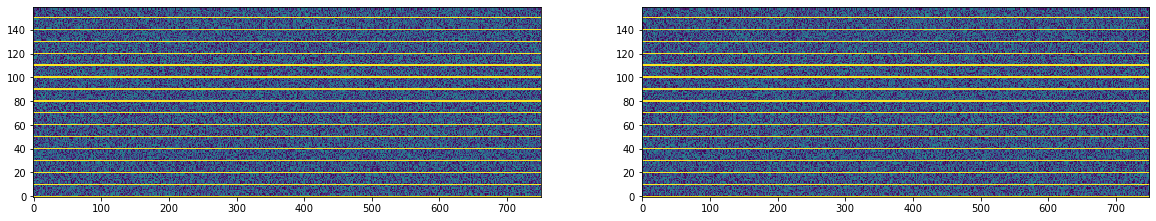

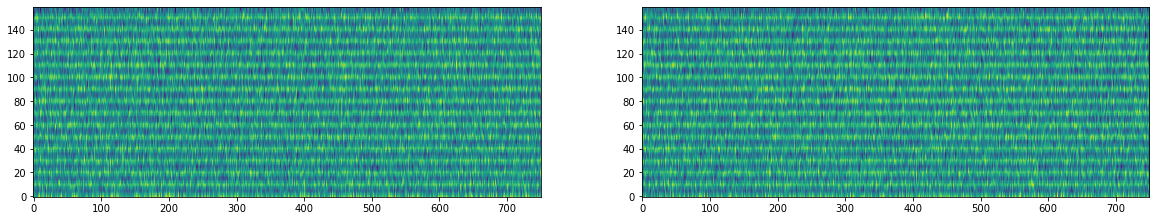

In [362]:
def GaussianBlur(inp, blur_strength=1.0):
    inp = inp.unsqueeze(1) # [B, height, width] -> [B, 1, height, width]
    var_ = blur_strength
    norm_dist = torch.distributions.normal.Normal(0, var_)
    conv_kernel = torch.stack([norm_dist.cdf(torch.tensor(i+0.5)) - norm_dist.cdf(torch.tensor(i-0.5)) for i in range(int(-var_*3),int(var_*3+1))], dim=0)[None, None, :, None]
    input_padding = (conv_kernel.shape[2]-1)//2
    out = F.conv2d(F.pad(inp, (0,0,input_padding,input_padding), mode='reflect'), conv_kernel).squeeze(1) # [B, 1, height, width] -> [B, height, width]
    return out

test_input = torch.rand(2,160,750) # [B, n_mel, dec_T]
test_input[:, 0::10, :] = 2.0
plot_data(test_input.numpy())
test_output = GaussianBlur(test_input, 2.0)
assert test_input.shape == test_output.shape, f'Output shape {test_output.shape} does not match input shape {test_input.shape}'
plot_data(test_output.numpy())

In [18]:
x = torch.zeros(1,3,10)# [B, dec_T, enc_T]
x[:,0,0] = 1
x[:,1,1] = 1
x[:,2,1] = 1
print(x)

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]])


tensor(4.4556e-09)
tensor(0.0052)
tensor(0.0002)


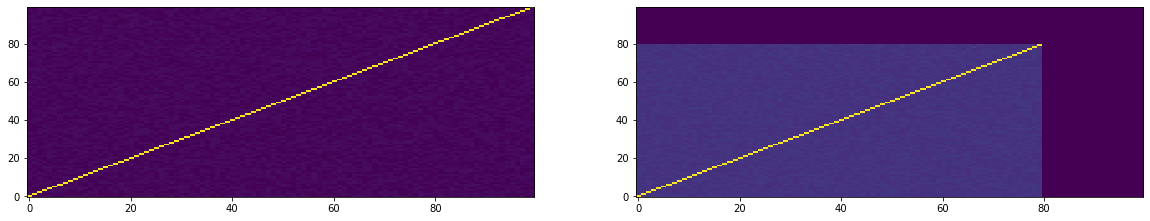

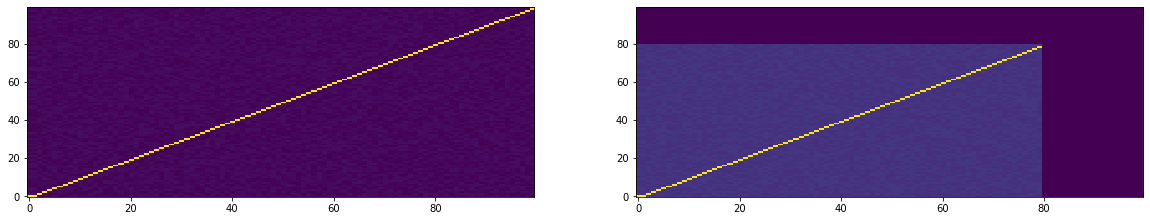

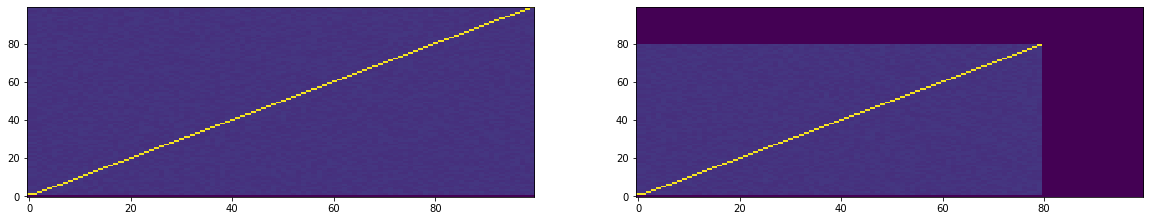

In [328]:
attention_scores = torch.rand(2, 1, 100, 100)*0.1
output_lengths = torch.tensor((100, 80))
text_lengths = torch.tensor((100, 80))
#attention_scores[:,:,::2,3] = 2
#attention_scores[:,:,1::2,5] = 2
attention_scores[(torch.arange(100)[None,:] - (torch.arange(100)[:,None]*1.).round() == 0)[None, None, ...].repeat(2, 1, 1, 1)] = 1.0
attention_scores = F.softmax(attention_scores*2, dim=3)
from CookieTTS.utils.model.utils import get_mask_from_lengths, get_mask_3d
import torch.nn.functional as F

# [B, n_layers, dec_T, enc_T]
if len(attention_scores.shape) == 4:
    attention_scores = attention_scores.mean(dim=(1,))# [B, n_layers, dec_T, enc_T] -> [B, dec_T, enc_T]
B, dec_T, enc_T = attention_scores.shape        # [B, dec_T, enc_T]
mask = ~get_mask_3d(output_lengths, text_lengths)# [B, dec_T, enc_T]
dec_shifted_attention_scores = torch.cat((attention_scores[:, 0:1], attention_scores[:, :-1]), dim=1) # Shift right by one [B, dec_T, enc_T]
dec_enc_shifted_attention_scores = F.pad(dec_shifted_attention_scores, (1,0))[:, :, :-1]# Shift right and up by one [B, dec_T, enc_T]
attention_scores.masked_fill_(mask, 0.0)                # [B, dec_T, enc_T]
dec_shifted_attention_scores.masked_fill_(mask, 0.0)    # [B, dec_T, enc_T]
dec_enc_shifted_attention_scores.masked_fill_(mask, 0.0)# [B, dec_T, enc_T]

plot_data(attention_scores.transpose(1, 2).numpy())
plot_data(dec_shifted_attention_scores.transpose(1, 2).numpy())
plot_data(dec_enc_shifted_attention_scores.transpose(1, 2).numpy())
att_loss = (((attention_scores - dec_shifted_attention_scores)**2) * ((attention_scores - dec_enc_shifted_attention_scores)**2)).sum() / (B*dec_T) # [B, dec_T, enc_T]
print(att_loss)
att_loss = ((attention_scores - dec_shifted_attention_scores)**2).sum() / (B*dec_T) # [B, dec_T, enc_T]
print(att_loss)
att_loss = ((attention_scores - dec_enc_shifted_attention_scores)**2).sum() / (B*dec_T) # [B, dec_T, enc_T]
print(att_loss)

tensor([[ True, False, False, False, False, False, False, False, False, False],
        [False,  True, False, False, False, False, False, False, False, False],
        [False, False,  True, False, False, False, False, False, False, False],
        [False, False, False,  True, False, False, False, False, False, False],
        [False, False, False, False,  True, False, False, False, False, False],
        [False, False, False, False, False,  True, False, False, False, False],
        [False, False, False, False, False, False,  True, False, False, False],
        [False, False, False, False, False, False, False,  True, False, False],
        [False, False, False, False, False, False, False, False,  True, False],
        [False, False, False, False, False, False, False, False, False,  True]])

torch.Size([2, 751, 100])

In [49]:
(1.0*1.0*0.0)

0.0

In [47]:
(1.0*1.0*1.0)

1.0

In [48]:
(1.0*1.0*1.0)

1.0

In [ ]:
def alignment_metric(alignments, input_lengths=None, output_lengths=None, average_across_batch=False):
    alignments = alignments.transpose(1,2) # [B, dec, enc] -> [B, enc, dec]
    # alignments [batch size, x, y]
    # input_lengths [batch size] for len_x
    # output_lengths [batch size] for len_y
    if input_lengths == None:
        input_lengths =  torch.ones(alignments.size(0), device=alignments.device)*(alignments.shape[1]-1) # [B] # 147
    if output_lengths == None:
        output_lengths = torch.ones(alignments.size(0), device=alignments.device)*(alignments.shape[2]-1) # [B] # 767
    batch_size = alignments.size(0)
    optimums = torch.sqrt(input_lengths.double().pow(2) + output_lengths.double().pow(2)).view(batch_size)
    
    # [B, enc, dec] -> [B, dec], [B, dec]
    values, cur_idxs = torch.max(alignments, 1) # get max value in column and location of max value
    
    cur_idxs = cur_idxs.float()
    prev_indx = torch.cat((cur_idxs[:,0][:,None], cur_idxs[:,:-1]), dim=1) # shift entire tensor by one.
    dist = ((prev_indx - cur_idxs).pow(2) + 1).pow(0.5) # [B, dec]
    dist.masked_fill_(~get_mask_from_lengths(output_lengths, max_len=dist.size(1)), 0.0) # set dist of padded to zero
    dist = dist.sum(dim=(1)) # get total dist for each B
    diagonalitys = (dist + 1.4142135)/optimums # dist / optimal dist
    
    alignments.masked_fill_(~get_mask_from_lengths(output_lengths, max_len=alignments.size(2))[:,None,:], 0.0)
    attm_enc_total = torch.sum(alignments, dim=2)# [B, enc, dec] -> [B, enc]
    
    # calc max (with padding ignored)
    attm_enc_total.masked_fill_(~get_mask_from_lengths(input_lengths, max_len=attm_enc_total.size(1)), 0.0)
    encoder_max_focus = attm_enc_total.max(dim=1)[0] # [B, enc] -> [B]
    
    # calc mean (with padding ignored)
    encoder_avg_focus = attm_enc_total.mean(dim=1)   # [B, enc] -> [B]
    encoder_avg_focus *= (attm_enc_total.size(1)/input_lengths.float())
    
    # calc min (with padding ignored)
    attm_enc_total.masked_fill_(~get_mask_from_lengths(input_lengths, max_len=attm_enc_total.size(1)), 1.0)
    encoder_min_focus = attm_enc_total.min(dim=1)[0] # [B, enc] -> [B]
    
    # calc average max attention (with padding ignored)
    values.masked_fill_(~get_mask_from_lengths(output_lengths, max_len=values.size(1)), 0.0) # because padding
    avg_prob = values.mean(dim=1)
    avg_prob *= (alignments.size(2)/output_lengths.float()) # because padding
    
    if average_across_batch:
        diagonalitys = diagonalitys.mean()
        encoder_max_focus = encoder_max_focus.mean()
        encoder_min_focus = encoder_min_focus.mean()
        encoder_avg_focus = encoder_avg_focus.mean()
        avg_prob = avg_prob.mean()
    return diagonalitys.cpu(), avg_prob.cpu(), encoder_max_focus.cpu(), encoder_min_focus.cpu(), encoder_avg_focus.cpu()

In [22]:
print(
    list(range(10)),
    list(range(10)),
    sep='\n')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [29]:
print(
    list(range(10))[:-1],
    list(range(10))[1:],
    sep='\n')

[0, 1, 2, 3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6, 7, 8, 9]


In [30]:
print(
    list(range(10))[:-2],
    list(range(10))[2:],
    sep='\n')

[0, 1, 2, 3, 4, 5, 6, 7]
[2, 3, 4, 5, 6, 7, 8, 9]


In [14]:
3**2/3**3

0.3333333333333333

In [148]:
import time
x = torch.rand(64).cuda().half()
t = torch.rand(64).cuda().half()
log_s = torch.rand(64).cuda().half()

@torch.jit.script
def fused_add_exp_div(x, t, log_s):
    return (x - t) / log_s.exp()

start_time = time.time()
for i in range(10000):
    _ = fused_add_exp_div(x, t, log_s)
print(f"Time Elapsed: {time.time()-start_time}")

Time Elapsed: 3.4484379291534424


In [149]:
import time
x = torch.rand(64).cuda().half()
t = torch.rand(64).cuda().half()
log_s = torch.rand(64).cuda().half()

start_time = time.time()
for i in range(10000):
    _ = (x - t) / log_s.exp()
print(f"Time Elapsed: {time.time()-start_time}")

Time Elapsed: 3.3774290084838867


In [163]:
import time
with torch.no_grad():
    x = torch.rand(600, 512).cuda().half()

    start_time = time.time()
    for i in range(600):
        x[i] = 1.0
    print(f"Time Elapsed: {time.time()-start_time}")

Time Elapsed: 0.14401841163635254


In [179]:
print(f"{0.24564684564564:.6f}")

0.245647


In [164]:
import time
with torch.no_grad():
    x = torch.rand(1, 512).cuda().half()

    start_time = time.time()
    for i in range(600):
        x[:] = 1.0
    print(f"Time Elapsed: {time.time()-start_time}")

Time Elapsed: 0.14201807975769043


In [173]:
for i in range(5):
    print(i, end='  |  ')
    print(100/(2**(i/2)))

0  |  100.0
1  |  70.71067811865474
2  |  50.0
3  |  35.35533905932737
4  |  25.0


In [174]:
torch.initial_seed()

1078719247006733

In [176]:
torch.random.get_rng_state()

tensor([ 13, 188, 135,  ...,   0,   0,   0], dtype=torch.uint8)

In [177]:
(512/320)**2

2.5600000000000005

In [175]:
import os
import numpy as np

def estimateSNR(z):
    '''
    This algorithm blindly estimates the SNR of a given audio signal, z.
    Method based on Wave Amplitude Distribution Analysis (WADA) Signal to Noise Ratio (SNR) estimation
    by Kim and Stern.
    Notes:
    * The values of the lookup table were pre-computed and stored in 'Alpha0.400000.txt'
    * This algorithm works best when the signal in question is speech and the noise is non-speech
    * Minimum estimated SNR = -20dB. Maximum estimated SNR = 100dB. SNRs outside of this range will default to one of these extrema
    * Algorithm works best for SNRs below 20dB
    Inputs:
        z (numpy array): The audio signal in question
    Outputs:
        SNR (float): SNR of input z (in dB)
    '''
    # Import LUT
    file = 'Alpha0.400000.txt'
    with open(file) as f:
        SNR = []
        G_z = []
        for line in f:
            contents = line.split(' ')
            SNR.append(float(contents[0]))
            G_z.append(float(contents[-1]))

    LUT = np.vstack((np.array(G_z), np.array(SNR)))

    # Normalize
    z -= z.mean()
    z /= np.max(np.abs(z))

    # Calculate G_z
    G_z = np.log(np.mean(np.abs(z))) - np.mean(np.log(np.abs(z)))

    # Use LUT, interpolate
    if G_z >= LUT[0,-1]:
        SNR = LUT[1,-1]
    elif G_z <= LUT[0,0]:
        SNR = LUT[1,0]
    else:
        idx = np.where(LUT[0]>G_z)[0][0]
        x1 = LUT[0, idx-1]
        x2 = LUT[0, idx]
        y1 = LUT[1, idx-1]
        y2 = LUT[1, idx]
        lam = (G_z - x2)/(x1 - x2)

        SNR = lam*y1 + (1-lam)*y2

    return SNR

In [98]:
print(f'[Flow-TTS/WaveGlow Mini WADA SNR] {estimateSNR(audio[0].cpu().numpy())}\n')

import soundfile as sf
fpaths = [
    r"H:\ClipperDatasetV2\SlicedDialogue\FiM\S1\s1e1\00_01_12_Celestia_Neutral_Very Noisy_Using the magic of the elements of harmony.flac",
    r"H:\ClipperDatasetV2\SlicedDialogue\FiM\S1\s1e1\00_01_14_Celestia_Neutral_Very Noisy_She defeated her younger sister.flac",
    r"H:\ClipperDatasetV2\SlicedDialogue\FiM\S1\s1e1\00_01_16_Celestia_Neutral_Very Noisy_And banished her permanently in the moon.flac",
    r"H:\ClipperDatasetV2\SlicedDialogue\FiM\S1\s1e1\00_02_57_Twilight_Neutral_Very Noisy_Spike_.flac",
    r"H:\ClipperDatasetV2\SlicedDialogue\FiM\S1\s1e1\00_03_01_Twilight_Neutral_Very Noisy_There you are.flac",
    r"H:\ClipperDatasetV2\SlicedDialogue\FiM\S1\s1e1\00_03_10_Spike_Neutral_Very Noisy_Well, it was a gift from Moondancer but.flac",
    r"H:\ClipperDatasetV2\SlicedDialogue\FiM\S1\s1e1\00_04_17_Spike_Neutral_Very Noisy_Okie dokie.flac",
    r"H:\ClipperDatasetV2\SlicedDialogue\FiM\S1\s1e1\00_05_30_Twilight_Neutral_Very Noisy_Important!.flac",
    r"H:\ClipperDatasetV2\SlicedDialogue\FiM\S1\s1e1\00_00_05_Celestia_Neutral__Once upon a time.flac",
    r"H:\ClipperDatasetV2\SlicedDialogue\FiM\S1\s1e1\00_00_06_Celestia_Neutral__In the magical land.flac",
    r"H:\ClipperDatasetV2\SlicedDialogue\FiM\S1\s1e1\00_00_08_Celestia_Neutral__Of Equestria.flac",
    r"H:\ClipperDatasetV2\SlicedDialogue\FiM\S1\s1e1\00_00_11_Celestia_Neutral__There were two regal sisters who ruled together.flac",
    r"H:\ClipperDatasetV2\SlicedDialogue\FiM\S1\s1e1\00_00_14_Celestia_Neutral__And created harmony for all the land.flac",
    r"H:\ClipperDatasetV2\SlicedDialogue\FiM\S9\s9e6\00_00_48_Pinkie_Neutral_Very Noisy_do you think they know we're here_.flac",
    r"H:\ClipperDatasetV2\SlicedDialogue\FiM\S9\s9e6\00_02_29_Fluttershy_Neutral_Very Noisy_I'm so proud they decided to honor us.flac",
    r"H:\ClipperDatasetV2\SlicedDialogue\FiM\S9\s9e6\00_07_48_Wind Sprint_Neutral_Very Noisy_Wait. you're rainbow dash, the wonderbolt_.flac",
    r"H:\ClipperDatasetV2\SlicedDialogue\FiM\S9\s9e6\00_07_20_Quibble Pants_Anxious_Very Noisy_i-i mean, you're a famous sports pony y-you'd know what to say.flac",
    r"H:\ClipperDatasetV2\SlicedDialogue\MLP Movie\00_01_25_Rachel Platten_Singing_Noisy_hey! hey! hey!.flac",
    r"H:\ClipperDatasetV2\SlicedDialogue\MLP Movie\00_01_31_Rachel Platten_Singing_Noisy_see the ponies trottin' down the street.flac",
]
for path in fpaths:
    gt_audio, samplerate = sf.read(path)
    print(f'[WADA SNR] {estimateSNR(gt_audio)}\n[File] "{path}"\n')

[Flow-TTS/WaveGlow Mini WADA SNR] 5.598042335203658

[WADA SNR] 13.568269321956702
[File] "H:\ClipperDatasetV2\SlicedDialogue\FiM\S1\s1e1\00_01_12_Celestia_Neutral_Very Noisy_Using the magic of the elements of harmony.flac"

[WADA SNR] 23.32231487885303
[File] "H:\ClipperDatasetV2\SlicedDialogue\FiM\S1\s1e1\00_01_14_Celestia_Neutral_Very Noisy_She defeated her younger sister.flac"

[WADA SNR] 18.20337964110681
[File] "H:\ClipperDatasetV2\SlicedDialogue\FiM\S1\s1e1\00_01_16_Celestia_Neutral_Very Noisy_And banished her permanently in the moon.flac"

[WADA SNR] 44.51911074224442
[File] "H:\ClipperDatasetV2\SlicedDialogue\FiM\S1\s1e1\00_02_57_Twilight_Neutral_Very Noisy_Spike_.flac"

[WADA SNR] 11.176038689288418
[File] "H:\ClipperDatasetV2\SlicedDialogue\FiM\S1\s1e1\00_03_01_Twilight_Neutral_Very Noisy_There you are.flac"

[WADA SNR] 18.890582480035082
[File] "H:\ClipperDatasetV2\SlicedDialogue\FiM\S1\s1e1\00_03_10_Spike_Neutral_Very Noisy_Well, it was a gift from Moondancer but.flac"

[W

In [29]:
hparams = checkpoint['hparams']
hparams.__dict__

{'_hparam_types': {'epochs': (int, False),
  'iters_per_checkpoint': (int, False),
  'seed': (int, False),
  'dynamic_loss_scaling': (bool, False),
  'fp16_run': (bool, False),
  'fp16_run_optlvl': (int, False),
  'distributed_run': (bool, False),
  'dist_backend': (str, False),
  'dist_url': (str, False),
  'cudnn_enabled': (bool, False),
  'cudnn_benchmark': (bool, False),
  'ignore_layers': (str, True),
  'frozen_modules': (str, True),
  'print_layer_names_during_startup': (bool, False),
  'n_tensorboard_outputs': (int, False),
  'check_files': (bool, False),
  'load_mel_from_disk': (bool, False),
  'speakerlist': (str, False),
  'use_saved_speakers': (bool, False),
  'raw_speaker_ids': (bool, False),
  'training_files': (str, False),
  'validation_files': (str, False),
  'text_cleaners': (str, True),
  'start_token': (str, False),
  'stop_token': (str, False),
  'max_wav_value': (float, False),
  'sampling_rate': (int, False),
  'filter_length': (int, False),
  'hop_length': (int, 

In [7]:
(2e-3-1e-5)*1e6

1990.0

torch.Size([1, 512, 16])


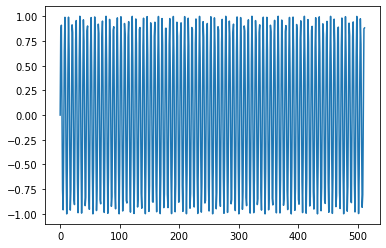

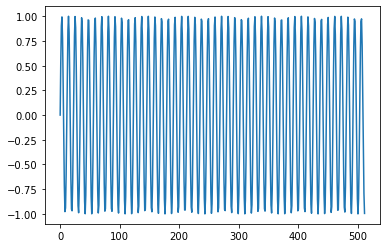

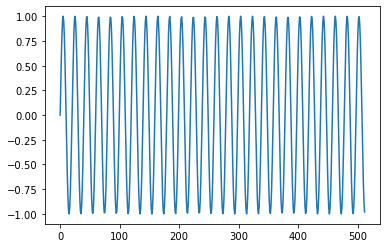

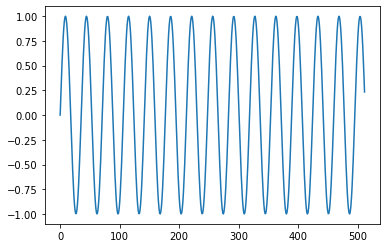

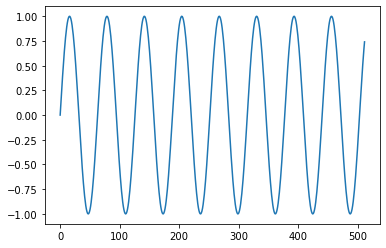

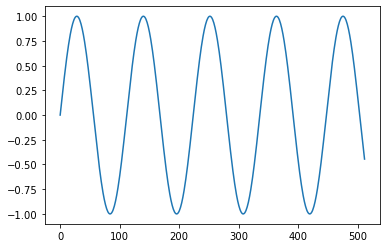

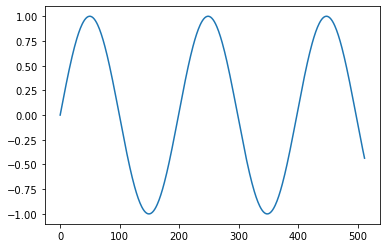

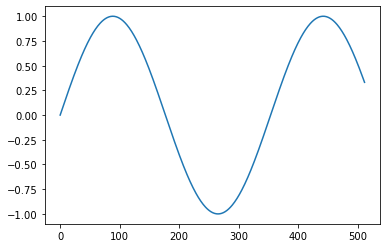

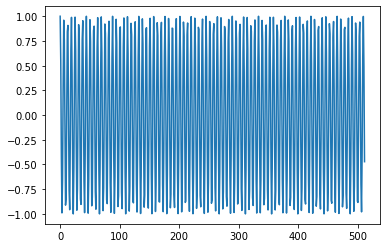

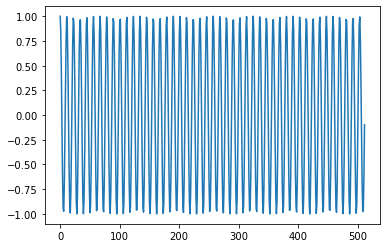

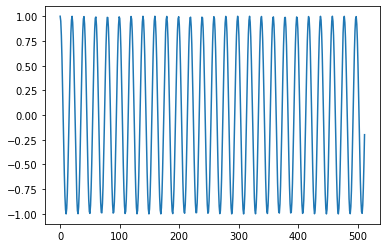

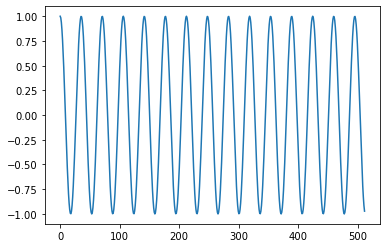

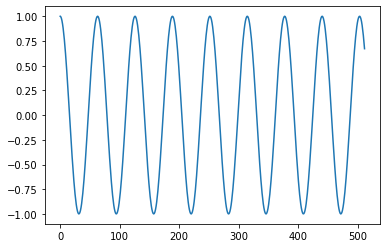

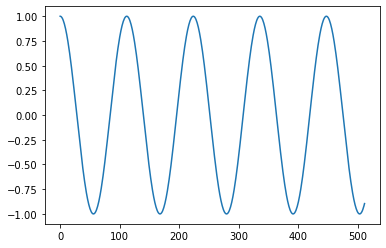

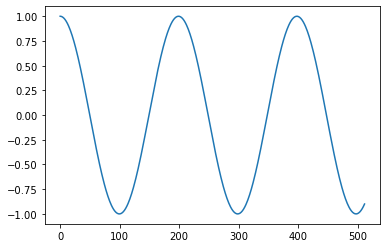

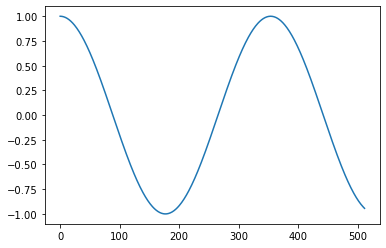

In [6]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

bsz = 1
demb = 16
range_scaler = torch.ones((1,))

inv_freq = torch.tensor(100)
pos_seq = torch.arange(0,512).float()

freq_seq = (torch.arange(0.0, demb, 2.0).unsqueeze(0)*range_scaler.unsqueeze(1)) / demb
inv_freq = 1 / (inv_freq.double() ** freq_seq.double())# [B, dim//2] # warning (to self)! this operation may go INF with very large 'frame per char' values! Keep inv_freq low or use full precision for this part
assert not (inv_freq==0).any(), 'zeros found in inv_freq'

pos_seq = pos_seq.expand(bsz, -1).unsqueeze(-1)# [dec_T]     -> [B, dec_T, 1]
inv_freq = inv_freq.unsqueeze(1)               # [B, dim//2] -> [B, 1, dim//2]
sinusoid_inp = pos_seq.to(inv_freq) @ inv_freq # [B, dec_T, 1] @ [B, 1, dim//2] -> [B, dec_T, dim//2]
pos_emb = torch.cat([sinusoid_inp.sin().to(pos_seq), sinusoid_inp.cos().to(pos_seq)], dim=-1)# [B, dec_T, dim//2] -> [B, dec_T, dim] OR [dec_T, dim//2] -> [dec_T, dim]

print(pos_emb.shape)

for i in range(pos_emb.shape[0]):
    for j in range(pos_emb.shape[2]):
        plt.plot(pos_emb[i,:,j].numpy())
        plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from math import sqrt

In [2]:
# https://github.com/CyberZHG/torch-multi-head-attention/blob/master/torch_multi_head_attention/multi_head_attention.py
class ScaledDotProductAttention(nn.Module):
    def forward(self, query, key, value, mask=None):
        dk = query.size()[-1]
        scores = query.matmul(key.transpose(-2, -1)) / sqrt(dk)# [B*n_head, dec_T, enc_dim//n_head] @ [B*n_head, enc_T, enc_dim//n_head].t() -> [B*n_head, dec_T, enc_T]
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -65500.0)# [B*n_head, dec_T, enc_T]
        attention = F.softmax(scores, dim=-1) # softmax along enc dim
        return attention.matmul(value), attention# [B*n_head, dec_T, enc_T] @ [B*n_head, enc_T, enc_dim//n_head] -> [B*n_head, dec_T, enc_dim//n_head]

# https://github.com/CyberZHG/torch-multi-head-attention/blob/master/torch_multi_head_attention/multi_head_attention.py
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 in_features,
                 head_num,
                 bias=True,
                 activation=F.relu):
        """Multi-head attention.
        :param in_features: Size of each input sample.
        :param head_num: Number of heads.
        :param bias: Whether to use the bias term.
        :param activation: The activation after each linear transformation.
        """
        super(MultiHeadAttention, self).__init__()
        if in_features % head_num != 0:
            raise ValueError('`in_features`({}) should be divisible by `head_num`({})'.format(in_features, head_num))
        self.in_features = in_features
        self.head_num = head_num
    
    def forward(self, q, k, v, mask=None):
        q = self._reshape_to_batches(q)# [B, dec_T, enc_dim] -> [B*n_head, dec_T, enc_dim//n_head]
        k = self._reshape_to_batches(k)# [B, enc_T, enc_dim] -> [B*n_head, enc_T, enc_dim//n_head]
        v = self._reshape_to_batches(v)# [B, enc_T, enc_dim] -> [B*n_head, enc_T, enc_dim//n_head]
        
        if mask is not None:
            mask = mask.repeat(self.head_num, 1, 1)# [B, dec_T, enc_T] -> [B*n_head, dec_T, enc_T]
        y, attention_scores = ScaledDotProductAttention()(q, k, v, mask)
        y = self._reshape_from_batches(y)# [B*n_head, dec_T, enc_dim//n_head] -> [B, dec_T, enc_dim]
        
        att_shape = attention_scores.shape
        attention_scores = attention_scores.view(att_shape[0]//self.head_num, self.head_num, *att_shape[1:])
        # [B*n_head, dec_T, enc_T] -> [B, n_head, dec_T, enc_T]
        return y
    
    def _reshape_to_batches(self, x):# [B, enc_T, enc_dim] -> [B*n_head, enc_T, enc_dim//n_head]
        batch_size, seq_len, in_feature = x.size()
        sub_dim = in_feature // self.head_num
        return x.reshape(batch_size, seq_len, self.head_num, sub_dim)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size * self.head_num, seq_len, sub_dim)
    
    def _reshape_from_batches(self, x):# [B*n_head, enc_T, enc_dim//n_head] -> [B, enc_T, enc_dim]
        batch_size, seq_len, in_feature = x.size()
        batch_size //= self.head_num
        out_dim = in_feature * self.head_num
        return x.reshape(batch_size, self.head_num, seq_len, in_feature)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size, seq_len, out_dim)

In [34]:
class BoundaryPredSeq(nn.Module): # VERY slow sequential, memory efficient
    def forward(self, scores, D=20):
        #scores [B, dec_T, enc_T]
        a = scores*0
        B = scores*0
        J = scores.shape[1]-1# dec max index
        I = scores.shape[2]-1# enc max index
        for j in range(scores.shape[1]):# dec
            for i in range(scores.shape[2]):# enc
                # get ai,j = P(Bi = j)
                for k in range(max(j-D, 0), j-1):
                    # get P(Bi-1 = k)
                    if i == 0:
                        stop_prob = (a[:, k, i]*0)+1# 1 if i' == 0
                    else:
                        stop_prob = a[:, k, i-1]
                    
                    # get P(Bi = j|Bi-1 = k)
                    energy_sum = a[:, j, i]*0
                    for m in range(k+1, min(k+D,J)):
                        energy_sum += scores[:, m, i]
                    cond_prob = scores[:, j, i] / energy_sum # ei,j / sum( ei,m )
                    
                    # get ai,j = P(Bi = j)
                    a[:, j, i] += (stop_prob * cond_prob)
                    del energy_sum, stop_prob
                
                # get Bi,j = P(Bi-1 < j <= Bi)
                for k in range(max(j-D, 0), j-1):
                    # get P(Bi-1 = k)
                    if i == 0:
                        stop_prob = a[:, k, i]
                    else:
                        stop_prob = a[:, k, i-1]
                    
                    # get P(Bi >= j|Bi-1 = k)
                    cond_sum = a[:, j, i]*0
                    for j_ in range(j, min(k+D,J)):
                        cond_sum += cond_prob[:,j_,i]# P(Bi = j'|Bi-1 = k)
                    
                    # get Bi,j = P(Bi-1 < j <= Bi)
                    B[:,j,i] += (stop_prob * cond_sum)
                    del cond_sum, stop_prob
        return B# [B, dec_T, enc_T] return the boundary probs

@torch.jit.script
def jitloop(B, a, cond_prob, scores, D: int, J: int, scores_shape_1: int):
    #
    for j in range(scores_shape_1):# dec
        # get Bi,j = P(Bi-1 < j <= Bi)
        for k in range(max(j-D, 0), j-1):
            # get P(Bi-1 = k)
            stop_prob = a[:, k, :]
            
            # get P(Bi >= j|Bi-1 = k)
            cond_sum = cond_prob[:,j:min(k+D,J),:].sum((1,))
            
            # get Bi,j = P(Bi-1 < j <= Bi)
            B[:,j,:] += (stop_prob * cond_sum)
    return B


@torch.jit.script
def jitloop(B, a, cond_prob, scores, D: int, J: int, scores_shape_1: int):
    #
    #cond_sums = cond_prob.new_zeros(cond_prob.shape)
    #cond = cond_prob[:, 0, :]*0
    #for j in range(scores_shape_1-1, -1, -1):
    #    cond += cond_prob[:, j, :]
    #    cond_sums[:, j, :] = cond
    
    #cond_sums = F.pad(cond_prob, (0, 0, 0, D))
    #cond_sums = torch.stack([cond_sums[:, j:scores_shape_1+j, :] for j in range(D)], dim=0).sum((0,))
    
    for j in range(scores_shape_1):# dec   
        for k in range(max(j-D, 0), j-1):
            # get P(Bi-1 = k)
            stop_prob = a[:, k, :]
            
            # get P(Bi >= j|Bi-1 = k)
            cond_sum = cond_prob[:,j:min(k+D,J),:].sum((1,))
            #cond_sum = cond_sums[:,j,:]
            
            # get Bi,j = P(Bi-1 < j <= Bi)
            B[:,j,:] += (stop_prob * cond_sum)
    return B

class BoundaryPredPara(nn.Module):# Parallel, fast in comparison and memory inefficient
    
    @torch.jit.script
    def forward(scores, D: int):
        #scores [B, dec_T, enc_T]
        a = scores*0     # P(Bi' = 0) = 1 if i' == 0 else 0
        a[:, 0, 0] = 1.0 # P(Bi' = 0) = 1 if i' == 0 else 0
        B = scores*0
        J = scores.shape[1]-1# dec max index
        I = scores.shape[2]-1# enc max index
        
        # get P(Bi = j|Bi-1 = k)
        energy_sum = F.pad(scores, (0,0,0,D))
        a_len = a.shape
        energy_sum = torch.stack([energy_sum[:, l:a_len[1]+l, :] for l in range(0, D-1)], dim=0).sum((0,))
        cond_prob = scores / energy_sum # ei,j / sum( ei,m )
        
        for i in range(scores.shape[2]):# enc
            # get ai,j = P(Bi = j)
            cond_prob_ = F.pad(cond_prob, (0,0,D,0))
            a_ = F.pad(a, (0,0,0,D))
            a[:, :, i] = torch.stack([ a_[:, k:a_len[1]+k, max(i-1, 0)]*cond_prob_[:,k:a_len[1]+k, max(i-1, 0)] for k in range(D-1)], dim=0).sum((0,))
        
        # get P(Bi ≥ j|Bi−1 = k)
        cond_prob_ = F.pad(cond_prob, (0,0,0,D))
        cond_prob = torch.stack([cond_prob_[:,j_:a_len[1]+j_,:] for j_ in range(D)], dim=0).sum((0,))
        
        # get Bi,j = P(Bi−1 < j ≤ Bi)
        cond_prob_ = F.pad(cond_prob, (0,0,D,0))
        a_ = F.pad(a, (0,0,0,D))
        a = torch.stack([ a_[:, k:a_len[1]+k, :]*cond_prob_[:,k:a_len[1]+k,:] for k in range(D-1)], dim=0).sum((0,))
        
        # 1.7s to Calc B using this method :/
        #B = jitloop(B, a, cond_prob, scores, D, J, scores.size(1))
        for j in range(scores.shape[1]):# dec   
            for k in range(max(j-D, 0), j-1):
                # get P(Bi-1 = k)
                stop_prob = a[:, k, :]
                
                # get P(Bi >= j|Bi-1 = k)
                cond_sum = cond_prob[:,j:min(k+D,J),:].sum((1,))
                #cond_sum = cond_sums[:,j,:]
                
                # get Bi,j = P(Bi-1 < j <= Bi)
                B[:,j,:] += (stop_prob * cond_sum)
        return B# [B, dec_T, enc_T] return the boundary probs

In [361]:
x = torch.rand(5).cuda().half()/1
print(x)
print(  (x.float().exp()*(2.71828**x)).to(x)  )

tensor([0.0183, 0.0598, 0.0052, 0.4585, 0.0587], device='cuda:0',
       dtype=torch.float16)
tensor([1.0371, 1.1270, 1.0098, 2.5020, 1.1250], device='cuda:0',
       dtype=torch.float16)


In [37]:
with torch.no_grad():
    bp = BoundaryPredPara().cuda()
    inpu = F.softmax(torch.rand(64, 300, 120).cuda()+1e-6, dim=2)# [B, dec_T, enc_T] Energies from Scaled Dot Product Attention
    inpu[0] = 1.
    inpu[1] = inpu[1].exp()
    outpu = bp(inpu, 20)
    print( inpu.shape,
          outpu.shape, # [B, dec_T, enc_T] Attention output from MoBoAligner
          sep='\n')
    print('isnan =', torch.isnan(outpu).any().item(), '\nisinf =', torch.isinf(outpu).any().item())
    outpu = outpu.transpose(1, 2)
    outpu_sm = F.softmax(outpu, dim=2)
    print("outpu.shape =", outpu.shape)
    _ = torch.rand(64, 512, 120).to(outpu) @ outpu
    print("_.shape =", _.shape)
    #print(_)
    
    import matplotlib
    %matplotlib inline
    import matplotlib.pylab as plt
    for i in range(4):
        plt.figure(figsize = (20,4))
        plt.imshow(outpu[i,:,:].cpu().numpy(), aspect='auto', interpolation='none')
        plt.show()
        plt.figure(figsize = (20,4))
        plt.imshow(outpu_sm[i,:,:].cpu().numpy(), aspect='auto', interpolation='none')
        plt.show()

AttributeError: 'NoneType' object has no attribute 'shape'

[ Att pseudocode ]

In [ ]:
# Inputs:
# GT_mel          [B, n_mel, dec_T]
# encoder_outputs [B, enc_T, enc_dim]

# Outputs:
# att_out    [B, dec_T, enc_dim]
# att_scores [B, dec_T, enc_T]

att_weights = torch.zeros(B, 2, enc_T, device=encoder_outputs.device, dtype=encoder_outputs.dtype)# [B, 2, enc_T]
acts = self.cond_conv(GT_mel)# [B, n_mel, dec_T] -> [B, att_dim, dec_T] (causal?) Conv/RNN to learn modifier for location
att_out = torch.zeros(B, enc_dim, device=encoder_outputs.device, dtype=encoder_outputs.dtype)
att_outs = []
att_scores = []
for di in dec_T:
    act = acts[:, :, di]# [B, att_dim, dec_T] -> [B, att_dim]
    act = self.act_linear(torch.cat((act, att_out), dim=1))# [B, att_dim+enc_dim] -> [B, att_dim]
    
    act = act.unsqueeze(1).repeat(1, enc_T, 1)# [B, att_dim] -> [B, enc_T, att_dim]
    loc_input = torch.cat((act.transpose(1, 2), att_weights), dim=1)# [B, enc_T, att_dim].t(), [B, 2, enc_T] -> [B, att_dim+2, enc_T]
    att_weights = self.location_conv(loc_input)# [B, att_dim+2, enc_T] -> [B, 1, enc_T]
    
    att_score = F.softmax(att_weights, dim=2)# [B, 1, enc_T] Softmax along Encoder
    att_out = (att_score @ encoder_outputs).squeeze(1) # [B, 1, enc_T] @ [B, enc_T, enc_dim] -> [B, enc_dim]
    att_outs.append(att_out)
    att_scores.append(att_scores)

att_outs = torch.stack(att_outs, dim=1)# arr of [B, enc_dim] -> [B, dec_T, enc_dim]
att_scores = torch.cat(att_scores, dim=1)# arr of [B, 1, enc_T] -> [B, dec_T, enc_T]

In [35]:
torch.ones(1,5).bool() & torch.ones(5,1).bool()

tensor([[True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True]])

In [41]:
import torch

loc = torch.tensor([2.0,]).unsqueeze(1)
pos = torch.arange(7)
pos = torch.stack((pos+0.5, pos-0.5), dim=1)

z1, z2 = ((loc-pos)/0.1).tanh().permute(1, 0)
z = (z1-z2)*0.5
print(z)

tensor([ 0.0000e+00, -4.5389e-05, -9.9991e-01, -4.5389e-05,  0.0000e+00,
         0.0000e+00,  0.0000e+00])


In [47]:
torch.rand(5).view(1,5,1)

tensor([[[0.9627],
         [0.2030],
         [0.4167],
         [0.6249],
         [0.9310]]])

In [37]:
torch.tensor(0.0001).log()

tensor(-9.2103)

In [18]:
import torch
x = torch.rand(4096, 4096).half().cuda()

In [19]:
%%timeit
for i in range(x.shape[1]):
    _ = x[:, i]

36.2 ms ± 91.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%%timeit
for i in range(x.shape[1]):
    _ = x[:, i:i+1]

36.9 ms ± 65.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [47]:
%%timeit
with torch.no_grad():
    inpu = F.softmax(torch.rand(64, 400, 120).cuda()+1e-6, dim=2)# [B, dec_T, enc_T] Energies from Scaled Dot Product Attention
    outpu = bp(inpu, 20)

286 ms ± 2.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
%%timeit
with torch.no_grad():
    inpu = F.softmax(torch.rand(16, 400, 120).cuda()+1e-6, dim=2)# [B, dec_T, enc_T] Energies from Scaled Dot Product Attention
    outpu = bp(inpu, 20)

264 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [252]:
x = -(-(torch.rand(8192,8192).half().cuda()*0.9997+0.0001).log()).log()
print( x.max(),
       x.min(),
      sep='\n')

tensor(7.6250, device='cuda:0', dtype=torch.float16)
tensor(-2.2207, device='cuda:0', dtype=torch.float16)


In [201]:
scores = torch.rand(64, 300, 120)#.cuda()
D = 20
torch.autograd.set_grad_enabled(False)

a = scores*0     # P(Bi' = 0) = 1 if i' == 0 else 0
a[:, 0, 0] = 1.0 # P(Bi' = 0) = 1 if i' == 0 else 0
J = scores.shape[1]-1# dec max index
I = scores.shape[2]-1# enc max index

# get P(Bi = j|Bi-1 = k)
energy_sum = F.pad(scores, (0,0,0,D))
a_len = a.shape
energy_sum = torch.stack([energy_sum[:, l:a_len[1]+l, :] for l in range(0, D-1)], dim=0).sum((0,))
cond_prob = scores / energy_sum # ei,j / sum( ei,m )

for i in range(scores.shape[2]):# enc
    # get ai,j = P(Bi = j)
    cond_prob_ = F.pad(cond_prob, (0,0,D,0))
    a_ = F.pad(a, (0,0,D,0))
    a[:, :, i] = torch.stack([ a_[:, k:a_len[1]+k, max(i-1, 0)]*cond_prob_[:,k:a_len[1]+k, max(i-1, 0)] for k in range(D-1)], dim=0).sum((0,))

# get P(Bi ≥ j|Bi−1 = k)
cond_prob_ = F.pad(cond_prob, (0,0,0,D))
cond_prob = torch.stack([cond_prob_[:,j_:a_len[1]+j_,:] for j_ in range(D)], dim=0).sum((0,))

# get Bi,j = P(Bi−1 < j ≤ Bi)
cond_prob_ = F.pad(cond_prob, (0,0,D,0))
a_ = F.pad(a, (0,0,0,D))
a = torch.stack([ a_[:, k:a_len[1]+k, :]*cond_prob_[:,k:a_len[1]+k,:] for k in range(D-1)], dim=0).sum((0,))

In [62]:
@torch.jit.script
def jitfunc(B, J: int, D: int, scores, a, cond_prob):
    B = scores*0
    for j in range(scores.shape[1]):# dec   
        for k in range(max(j-D, 0), j-1):
            # get P(Bi-1 = k)
            stop_prob = a[:, k, :]
            
            # get P(Bi >= j|Bi-1 = k)
            cond_sum = cond_prob[:,j:min(k+D,J),:].sum((1,))
            
            # get Bi,j = P(Bi-1 < j <= Bi)
            B[:,j,:] += (stop_prob * cond_sum)
    return B

In [63]:
%%timeit
_ = jitfunc(B, J, D, scores, a, cond_prob)

558 ms ± 40.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [75]:
max_ = 1.0
min_ = 0.1
torch.rand(5,5) * (max_-min_) + min_

tensor([[0.9580, 0.4380, 0.1790, 0.2002, 0.6656],
        [0.7488, 0.2313, 0.3324, 0.8602, 0.9866],
        [0.3813, 0.7948, 0.1974, 0.7244, 0.5829],
        [0.7752, 0.3605, 0.8380, 0.3836, 0.7117],
        [0.1719, 0.8826, 0.8936, 0.1858, 0.5762]])

In [46]:
B_target = B.clone()

In [36]:
torch.cuda.empty_cache()

In [21]:
mha = MultiHeadAttention(16, 2, False)

In [22]:
# q [B, dec_T, enc_dim] -> [B*n_head, dec_T, enc_dim//n_head]
# k [B, enc_T, enc_dim] -> [B*n_head, enc_T, enc_dim//n_head]
# v [B, enc_T, enc_dim] -> [B*n_head, enc_T, enc_dim//n_head]
B = 2
enc_T = 6
dec_T = 20
att_dim = 16

k = torch.rand(B, enc_T, att_dim)
v = torch.rand(B, enc_T, att_dim)
q = torch.rand(B, dec_T, att_dim)
o = mha(q, k, v)
o.shape

torch.Size([2, 20, 16])

In [22]:
import torch
((torch.tensor(0.030)/0.006)**2)*0.006

tensor(0.1500)

In [12]:
import torch
x = torch.rand(1,5,5)
mask = (torch.arange(5) < 2).view(1, 5, 1)
print(x)
print(mask)
x.data.masked_fill_(mask, 0.0)
print(x)

tensor([[[0.2266, 0.2117, 0.6832, 0.9830, 0.8803],
         [0.8369, 0.8312, 0.2156, 0.9512, 0.8908],
         [0.6612, 0.1522, 0.0988, 0.1315, 0.8801],
         [0.4403, 0.9496, 0.1794, 0.9415, 0.6164],
         [0.5508, 0.4646, 0.4797, 0.5090, 0.4450]]])
tensor([[[ True],
         [ True],
         [False],
         [False],
         [False]]])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.6612, 0.1522, 0.0988, 0.1315, 0.8801],
         [0.4403, 0.9496, 0.1794, 0.9415, 0.6164],
         [0.5508, 0.4646, 0.4797, 0.5090, 0.4450]]])
